# Tutorial 11d - Super-Resolution GAN to Enhance Wavefront Map Data
This notebook demonstrates the use of Optiland and PyTorch to create a super-resolution GAN (SR GAN) to upscale low-resolution wavefront data (32x32) into high-resolution data (128x128).

This notebook is broken down into the following steps:

1. **Wavefront Map Generation**: Using Zernike polynomials to generate wavefront maps, which represent the optical aberrations of a lens system.
2. **Dataset Creation**: Building a PyTorch dataset that includes low-resolution and high-resolution wavefront maps, with added noise to simulate real-world conditions.
3. **Generator Network Definition**: Defining a super-resolution GAN that takes low-resolution wavefront maps and generates high-resolution maps.
4. **Discriminator Network Definition**: Defining a discriminator network that distinguishes between real and generated high-resolution wavefront maps.
5. **Training**: Training the GAN using adversarial and pixel-wise loss functions.
6. **Evaluation**: Assessing the performance of the trained model by comparing generated wavefront maps to the original high-resolution maps.
7. **Comparison with Analytical Results**: Validating the model's performance by comparing the generated results with analytical solutions from Optiland.

By the end of this notebook, you will have a trained super-resolution GAN capable of enhancing the resolution of wavefront data, which can be applied to improve the accuracy of optical simulations or real-world measurements.

### Background

##### What is a GAN?

A **Generative Adversarial Network (GAN)** is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. GANs consist of two neural networks, the **generator** and the **discriminator**, which compete against each other in a game-theoretic scenario.

- **Generator**: This network generates new data instances that resemble the training data. It takes random noise as input and transforms it into a data sample.
- **Discriminator**: This network evaluates the authenticity of the data samples. It tries to distinguish between real data (from the training set) and fake data (produced by the generator).

The generator aims to produce data that is indistinguishable from real data, while the discriminator aims to correctly identify real vs. fake data. Through this adversarial process, both networks improve over time.

##### What is a Super-Resolution GAN (SRGAN)?

A **Super-Resolution GAN (SRGAN)** is a type of GAN specifically designed for image super-resolution tasks. Image super-resolution involves enhancing the resolution of an image, i.e., increasing the pixel count and improving the quality of the image. SRGANs are particularly useful in applications where high-quality images are required but only low-resolution images are available, such as medical imaging, satellite imaging, and enhancing old photographs.

It is important to note that there are simpler methods for enhancing the resolution of images, such as interpolation techniques (e.g., bilinear or bicubic interpolation). These methods are straightforward and computationally less intensive. While these simpler methods may be sufficient for the wavefront data we're using in this exercise, we employ an SRGAN in this notebook as an educational exercise and to demonstrate SRGAN capabilities.

In general, while interpolation methods can provide decent results, SRGANs have the potential to produce higher-quality images by learning complex patterns and details from the training data. This makes SRGANs particularly powerful for applications where high-quality image reconstruction is critical.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from optiland import wavefront
from optiland.samples.objectives import ReverseTelephoto
from optiland.zernike import ZernikeStandard

## Step 1: Set up Zernike-based wavefront map generation

To generate wavefront maps, we use Zernike polynomials, which are a set of polynomials that are orthogonal on the unit disk. These polynomials are commonly used in optics to represent wavefront data. 

In this section, we will create two helper functions:

1. `generate_wavefront` generates wavefront maps using Zernike polynomials.
2. `plot_wavefront` visualizes a generated wavefront map.

In [2]:
def generate_wavefront(z, num_points=32):
    x, y = np.meshgrid(np.linspace(-1, 1, num_points), np.linspace(-1, 1, num_points))
    radius = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    values = z.poly(radius, phi)

    values[radius > 1] = 0.0

    # Normalize the values between -1 and 1
    values = (values - np.min(values)) / (np.max(values) - np.min(values))
    values = 2 * values - 1

    return values

In [3]:
def plot_wavefront(values):
    _, ax = plt.subplots(figsize=(7, 5.5))
    im = ax.imshow(np.flipud(values), extent=[-1, 1, -1, 1])

    ax.set_xlabel("Pupil X")
    ax.set_ylabel("Pupil Y")
    plt.colorbar(im)
    plt.show()

As an example, let's generate a Zernike instance with random coefficients, then plot the resulting map.

In [4]:
z = ZernikeStandard(np.random.rand(10))

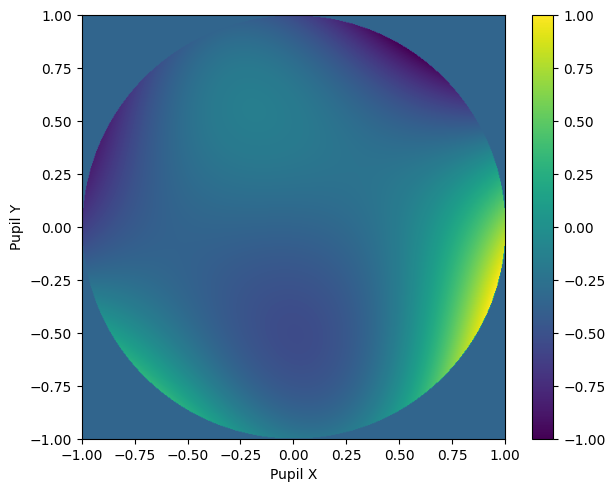

In [5]:
w = generate_wavefront(z, num_points=512)
plot_wavefront(w)

## Step 2: Build PyTorch wavefront dataset

To build a PyTorch dataset for training the super-resolution GAN, we need to create a custom dataset class that generates pairs of low-resolution and high-resolution wavefront maps. The `WavefrontDataset` class is defined to handle this task. It generates random Zernike coefficients to create wavefront maps, adds noise to the low-resolution maps to simulate real-world conditions, and returns the corresponding low-resolution and high-resolution maps as tensors.

Ideally, we would use measured or simulated wavefront data from actual optical systems. However, in this example, we opt for wavefront maps based on Zernike polynomials for simplicity. While the model is trained on simulated (fake) data, it could be extended to work with real wavefront data via e.g., transfer learning methods.

In [6]:
class WavefrontDataset(Dataset):
    def __init__(self, num_samples=1000, low_res=32, high_res=128, noise_level=0.01):
        self.num_samples = num_samples
        self.low_res = low_res
        self.high_res = high_res
        self.noise_level = noise_level

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random Zernike coefficients
        coeffs = np.random.uniform(-1, 1, size=15)  # First 15 Zernike modes
        zernike = ZernikeStandard(coeffs)

        # High-res wavefront
        high_res_map = generate_wavefront(zernike, num_points=self.high_res)

        # Low-res wavefront (downsampled + noise)
        low_res_map = generate_wavefront(zernike, num_points=self.low_res)
        low_res_map += np.random.normal(0, self.noise_level, low_res_map.shape)

        return torch.tensor(low_res_map, dtype=torch.float32), torch.tensor(
            high_res_map,
            dtype=torch.float32,
        )

## Step 3: Define generator network

In this section, we define the generator network for the super-resolution GAN. The generator network is responsible for taking low-resolution wavefront maps and generating high-resolution maps. The architecture of the generator includes:

- **Initial Feature Extraction**: A convolutional layer followed by a PReLU activation function to extract initial features from the input.
- **Residual Blocks**: A series of 16 residual blocks, each containing two convolutional layers, batch normalization, and PReLU activation. These blocks help in learning complex features and maintaining the stability of the network.
- **Post-residual Block**: A convolutional layer followed by batch normalization to process the output of the residual blocks.
- **Upsampling Layers**: Two transposed convolutional layers with PReLU activation to upscale the feature maps from low resolution to high resolution.
- **Final Output Layer**: A convolutional layer followed by a Tanh activation function to generate the final high-resolution wavefront map.

In [ ]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection


# Define the Generator
class SRGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial Feature Extraction
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
        )

        # Residual Blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(16)],  # 16 Residual Blocks
        )

        # Post-residual Block
        self.post_residual = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
        )

        # Upsampling Layers
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 32x32 -> 64x64
            nn.PReLU(),
            nn.ConvTranspose2d(
                64,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 64x64 -> 128x128
            nn.PReLU(),
        )

        # Final Output Layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=9, stride=1, padding=4),
            nn.Tanh(),  # Normalize output to [-1, 1]
        )

    def forward(self, x):
        initial_features = self.initial(x)
        residual_output = self.residual_blocks(initial_features)
        post_residual = self.post_residual(residual_output)
        combined = initial_features + post_residual  # Global skip connection
        upsampled = self.upsample(combined)
        output = self.final(upsampled)
        return output

## Step 4: Define discriminator network

The discriminator network is responsible for distinguishing between real high-resolution wavefront maps and those generated by the generator. It is a binary classifier that outputs a probability indicating whether the input is real or fake. The architecture of the discriminator includes:

- **Initial Convolutional Layers**: Two convolutional layers with LeakyReLU activation functions to extract features from the input wavefront maps.
- **Flattening Layer**: A layer to flatten the feature maps into a 1D tensor.
- **Fully Connected Layer**: A linear layer to map the flattened tensor to a single output value.
- **Sigmoid Activation**: A sigmoid activation function to output a probability value between 0 and 1.

In [8]:
# Discriminator: Distinguishes true vs. fake high-res
class Discriminator(nn.Module):
    def __init__(self, high_res):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (high_res // 2) * (high_res // 2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Model Initialization Function
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

## Step 5: Initialize dataloader, models, optimizers, and loss functions

In this section, we initialize the dataloader, models, optimizers, and loss functions required for training the super-resolution GAN. The dataloader is responsible for loading the wavefront dataset and providing batches of data during training. The generator and discriminator models are instantiated and their weights are initialized. We also define the optimizers for both models and the loss functions used to train the GAN. The adversarial loss function helps the generator produce realistic high-resolution wavefront maps, while the pixel-wise loss function ensures that the generated maps are close to the ground truth.

In [10]:
# Define dataset & dataloader
dataset = WavefrontDataset(num_samples=1000)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
# Hyperparameters
lr_generator = 2e-4  # Learning rate for the generator
lr_discriminator = 1e-5  # Learning rate for the discriminator
epochs = 100
lambda_L1 = 100  # L1 loss weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [12]:
# Instantiate models
generator = SRGANGenerator().to(device)
initialize_weights(generator)

discriminator = Discriminator(high_res=128).to(device)
initialize_weights(discriminator)

In [13]:
# Optimizers and loss
gen_opt = Adam(generator.parameters(), lr=lr_generator)
disc_opt = Adam(discriminator.parameters(), lr=lr_discriminator)
adversarial_loss = nn.BCELoss()
pixel_loss = nn.MSELoss()

## Step 6: Train the model using PyTorch

In this section, we train the super-resolution GAN using the PyTorch framework. The training process involves alternating between training the generator and the discriminator. The generator aims to produce high-resolution wavefront maps from low-resolution inputs, while the discriminator attempts to distinguish between real and generated high-resolution maps.

The training loop consists of the following steps:

1. **Load Data**: For each batch, load the low-resolution and high-resolution wavefront maps from the dataloader.
2. **Train Discriminator**:
    - Generate high-resolution maps using the generator.
    - Compute the discriminator loss on real high-resolution maps and generated high-resolution maps.
    - Backpropagate the loss and update the discriminator's weights.
3. **Train Generator**:
    - Compute the adversarial loss by passing the generated high-resolution maps through the discriminator.
    - Compute the pixel-wise loss between the generated and real high-resolution maps.
    - Combine the adversarial and pixel-wise losses.
    - Backpropagate the combined loss and update the generator's weights.
4. **Logging**: Print the generator and discriminator losses every 10 epochs to monitor the training progress.

The training loop runs for 100 epochs, and the models are saved at the end of the training process.

In [ ]:
generator.train()

# Training loop
for epoch in range(epochs):
    for low_res, high_res in dataloader:
        low_res, high_res = low_res.to(device), high_res.to(device)

        # Train discriminator
        disc_opt.zero_grad()
        fake_high_res = generator(low_res.unsqueeze(1))
        real_label = torch.ones((high_res.size(0), 1), device=device)
        fake_label = torch.zeros((high_res.size(0), 1), device=device)
        real_loss = adversarial_loss(discriminator(high_res.unsqueeze(1)), real_label)
        fake_loss = adversarial_loss(discriminator(fake_high_res.detach()), fake_label)
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        disc_opt.step()

        # Train generator
        gen_opt.zero_grad()
        adv_loss = adversarial_loss(discriminator(fake_high_res), real_label)
        pix_loss = pixel_loss(fake_high_res, high_res.unsqueeze(1)) * lambda_L1
        gen_loss = adv_loss + pix_loss
        gen_loss.backward()
        gen_opt.step()

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{epochs}] - Gen Loss: {gen_loss:.4f}, "
            f"Disc Loss: {disc_loss:.4f}",
        )

Epoch [10/100] - Gen Loss: 2.6620, Disc Loss: 0.3098
Epoch [20/100] - Gen Loss: 2.2934, Disc Loss: 0.3450
Epoch [30/100] - Gen Loss: 1.8378, Disc Loss: 0.4859
Epoch [40/100] - Gen Loss: 1.3165, Disc Loss: 0.5580
Epoch [50/100] - Gen Loss: 1.2494, Disc Loss: 0.5887
Epoch [60/100] - Gen Loss: 1.3649, Disc Loss: 0.5726
Epoch [70/100] - Gen Loss: 1.1867, Disc Loss: 0.5947
Epoch [80/100] - Gen Loss: 1.0540, Disc Loss: 0.6072
Epoch [90/100] - Gen Loss: 1.1497, Disc Loss: 0.6046
Epoch [100/100] - Gen Loss: 1.2078, Disc Loss: 0.6181


In [15]:
# Save the generator and discriminator
torch.save(generator.state_dict(), f"generator_epoch_{epoch + 1}.pth")
torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch + 1}.pth")

## Step 7: Assess model performance

In this section, we assess the performance of the trained super-resolution GAN by comparing the generated high-resolution wavefront maps to the original high-resolution maps. We use both qualitative and quantitative metrics for evaluation:

1. **Qualitative Assessment**: Visual inspection of the generated wavefront maps compared to the original maps. This involves plotting the real low-resolution, real high-resolution, and generated high-resolution maps side by side.
2. **Quantitative Metrics**: Calculation of loss values to quantify the performance of the model. The adversarial loss (`adv_loss`), pixel-wise loss (`pix_loss`), and discriminator loss (`disc_loss`) are monitored to evaluate the training progress and the quality of the generated maps.

In [16]:
def plot_wavefront(generator, dataset=dataset):
    # Set to evaluation mode
    generator.eval()

    # Generate a wavefront
    low_res, high_res = dataset[0]
    low_res = low_res.unsqueeze(0).unsqueeze(0).to(device)
    fake_high_res = generator(low_res)
    fake_high_res = fake_high_res.squeeze().detach().cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Plot real low-res
    im0 = axes[0].imshow(low_res.squeeze().cpu().numpy(), extent=[-1, 1, -1, 1])
    axes[0].set_title("Real Low-Res")
    plt.colorbar(im0, ax=axes[0])

    # Plot real high-res
    im1 = axes[1].imshow(high_res.squeeze().cpu().numpy(), extent=[-1, 1, -1, 1])
    axes[1].set_title("Real High-Res")
    plt.colorbar(im1, ax=axes[1])

    # Plot fake high-res
    im2 = axes[2].imshow(fake_high_res, extent=[-1, 1, -1, 1])
    axes[2].set_title("Fake High-Res")
    plt.colorbar(im2, ax=axes[2])

    plt.show()

    # Return to training mode
    generator.train()

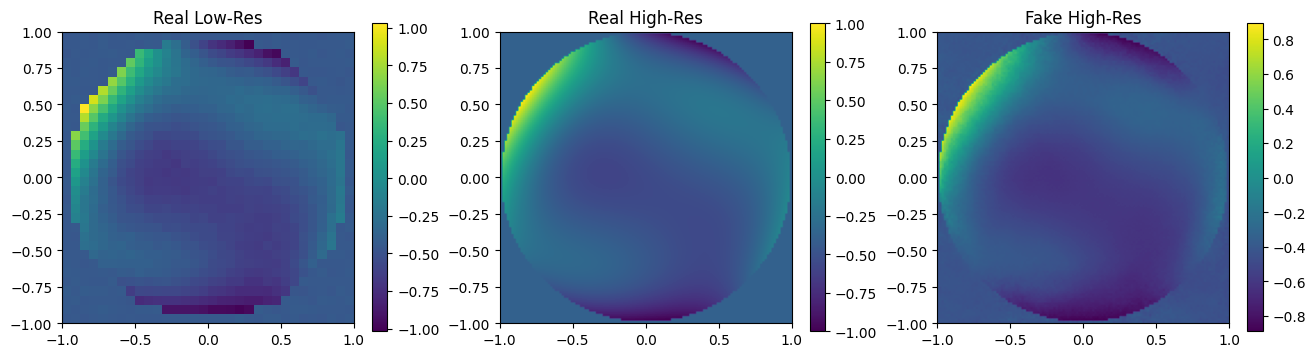

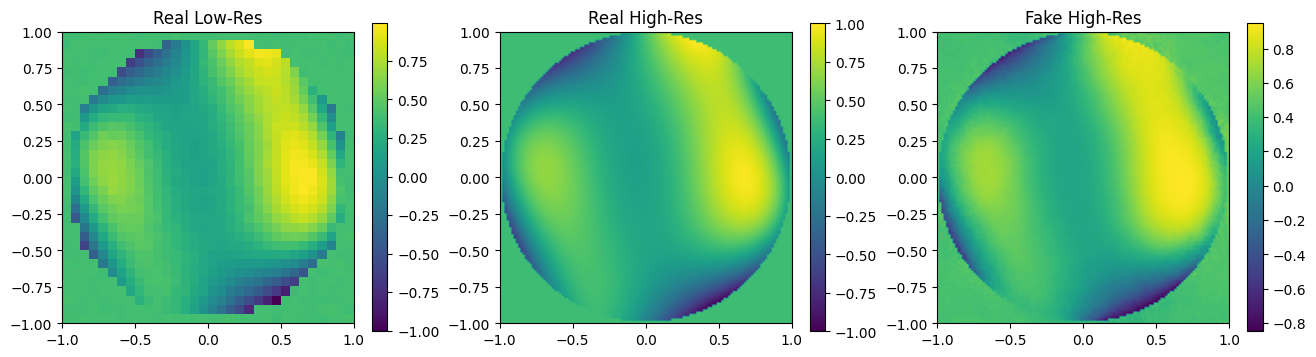

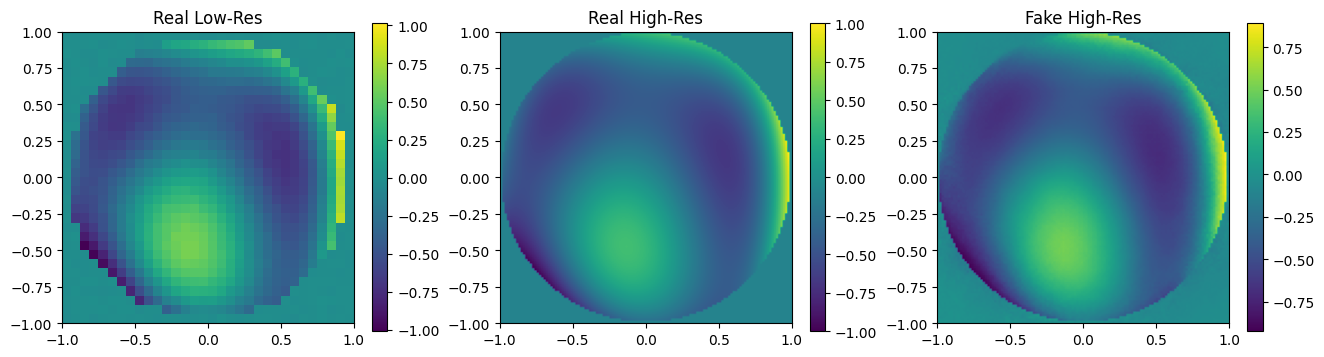

In [17]:
for _ in range(3):
    plot_wavefront(generator)

Here, we see the low-resolution maps (left), _real_ high-resolution maps (middle), and _generated_ high-resolution maps (right). Qualitatively, we see that the generated maps match the real maps quite well.

In [18]:
print(f"Final Discriminator Loss: {disc_loss.item():.4f}")
print(f"Final Adversarial Loss: {adv_loss.item():.4f}")
print(f"Final Pixel-wise Loss: {pix_loss.item():.4f}")

Final Discriminator Loss: 0.6181
Final Adversarial Loss: 0.7525
Final Pixel-wise Loss: 0.4553


## Step 8: Compare model performance to analytical result

In this section, we qualitatively compare the performance of the trained super-resolution GAN to analytical results obtained from Optiland. This involves generating wavefront maps using ray tracing and comparing them to the maps generated by the GAN.

First, we create twp helper functions:

1. `process_wavefront` is used to normalize the wavefront to the range (-1, 1) and remove NaNs.
2. `rescale_wavefront` is used to rescale a wavefront to absolute units based on the low-resolution wavefront min/max values.
3. `compare_analytical_result` is used to generate low- and hig-res wavefronts using Optiland, generate a high-res map using the GAN, then plot all maps.

In [19]:
def process_wavefront(wavefront):
    data = (wavefront - np.nanmin(wavefront)) / (
        np.nanmax(wavefront) - np.nanmin(wavefront)
    )
    data = 2 * data - 1

    # set NaN values to 0
    data[np.isnan(data)] = 0

    return data

In [20]:
def rescale_wavefront(wavefront, min_val, max_val):
    data = (wavefront + 1) / 2
    data = data * (max_val - min_val) + min_val

    return data

In [21]:
def compare_analytical_result(lens, field):
    # Generate the real low-res and high-res wavefronts
    opd = wavefront.OPD(lens, field=field, wavelength=0.55, num_rings=25)
    real_low_res = opd.generate_opd_map(num_points=32)["z"]
    real_high_res = opd.generate_opd_map(num_points=128)["z"]

    # get scale of nominal low-res wavefront
    min_val, max_val = np.nanmin(real_low_res), np.nanmax(real_low_res)

    # Process the wavefronts
    real_low_res = process_wavefront(real_low_res)
    real_high_res = process_wavefront(real_high_res)

    # Add batch and channel dimensions, then put on GPU
    real_low_res = (
        torch.tensor(real_low_res, dtype=torch.float32)
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
    )

    # Generate the fake high-res wavefront
    fake_high_res = generator(real_low_res)
    fake_high_res = (
        fake_high_res.squeeze().detach().cpu().numpy()
    )  # Remove batch and channel dimensions

    # Move low-res wavefront back to CPU
    real_low_res = real_low_res.squeeze().cpu().numpy()

    # Plot all
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Rescale wavefronts
    real_low_res = rescale_wavefront(real_low_res, min_val, max_val)
    real_high_res = rescale_wavefront(real_high_res, min_val, max_val)
    fake_high_res = rescale_wavefront(fake_high_res, min_val, max_val)

    # Plot real low-res
    im0 = axes[0].imshow(real_low_res, extent=[-1, 1, -1, 1])
    axes[0].set_title("Real Low-Res")
    plt.colorbar(im0, ax=axes[0])

    # Plot real high-res
    im1 = axes[1].imshow(real_high_res, extent=[-1, 1, -1, 1])
    axes[1].set_title("Real High-Res")
    plt.colorbar(im1, ax=axes[1])

    # Plot fake high-res
    im2 = axes[2].imshow(fake_high_res, extent=[-1, 1, -1, 1])
    axes[2].set_title("Fake High-Res")
    plt.colorbar(im2, ax=axes[2])

    plt.show()

We will use one of the sample lenses from Optiland, which is a reverse telephoto design.

In [22]:
lens = ReverseTelephoto()

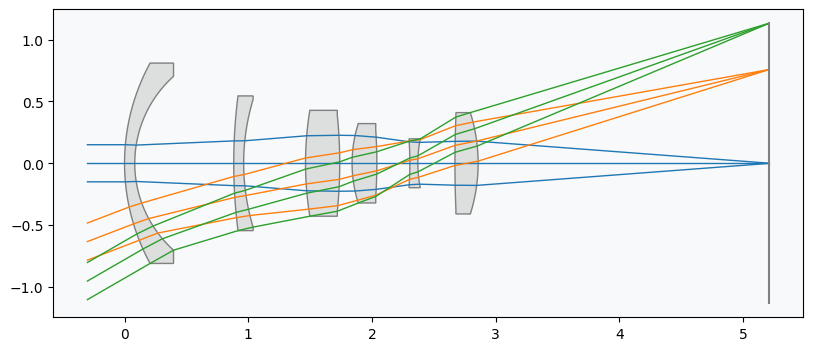

In [23]:
lens.draw()

Finally, let's compare the results at a few different normalized field coordinates.

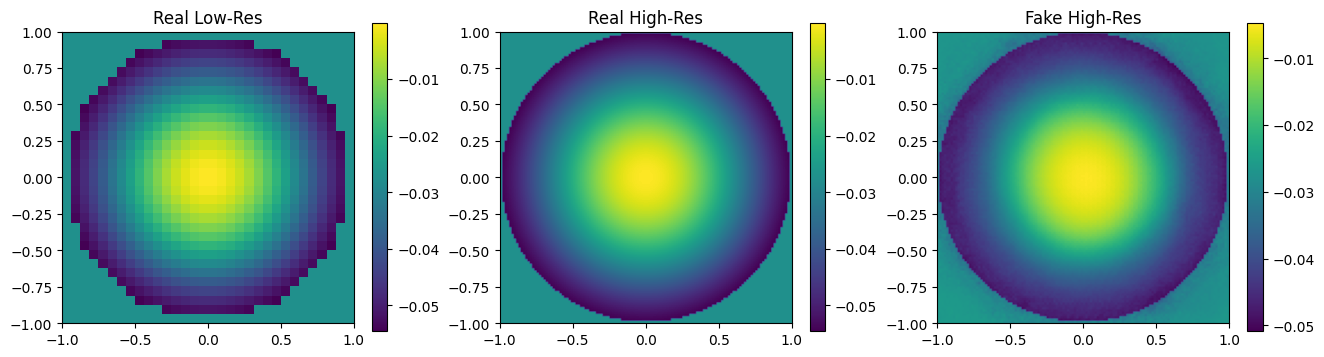

In [26]:
compare_analytical_result(lens, field=(0, 0))

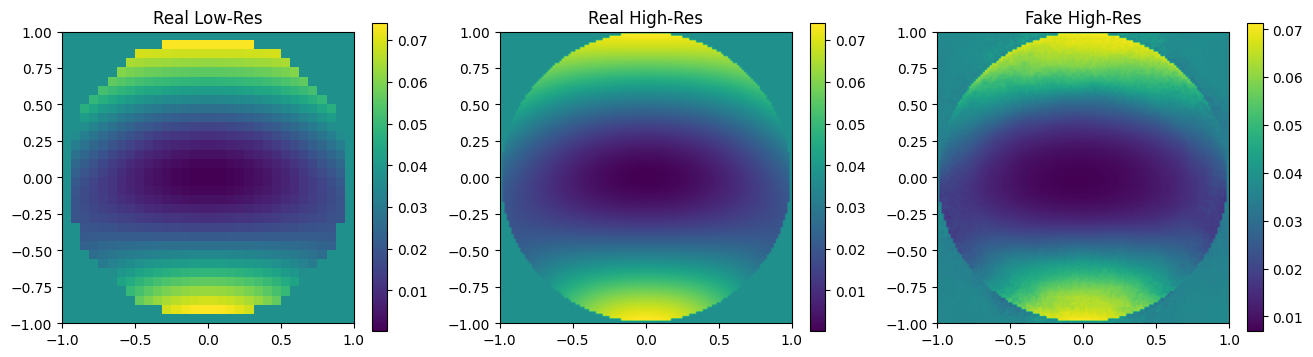

In [ ]:
compare_analytical_result(lens, field=(0, 1))

## Conclusions

- The super-resolution GAN successfully enhanced the resolution of wavefront data from 32x32 to 128x128.
- The generator and discriminator networks were trained using adversarial and pixel-wise loss functions.
- The generated high-resolution wavefront maps closely matched the real high-resolution maps.
- The model's performance was compared against analytical results from Optiland, demonstrating its practical applicability.
- Future work could involve training on real wavefront data and exploring transfer learning techniques to further improve performance on real data. Furthermore, more complex network architectures could be investigated to enhance the performance and efficiency of the super-resolution GAN.